In [1]:
# Importing packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchmetrics
import torchinfo
import torch.nn.functional as F
import cv2

In [2]:
# Data pathes
train_images = 'data/Massachusetts/tiff/train'
train_labels = 'data/Massachusetts/tiff/train_labels'
val_images = 'data/Massachusetts/tiff/val'
val_labels = 'data/Massachusetts/tiff/val_labels'
test_images = 'data/Massachusetts/tiff/test'
test_labels = 'data/Massachusetts/tiff/test_labels'

In [3]:
# Hyperparams
DEVICE = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
IN_CHANNELS = 3
CLASSES = 2
TRAIN_BATCH = 8
VALID_BATCH = 2
NUM_WORKERS = 8
LR = 0.001
EPOCHS = 100

In [4]:
# Train and test augmentations

A_train = A.Compose([#A.Resize(224, 224, interpolation=cv2.INTER_NEAREST), 
                     A.RandomCrop(height=256, width=256, always_apply=True),
                     A.OneOf([
                       A.VerticalFlip(p=1),
                       A.HorizontalFlip(p=1),
                       A.RandomRotate90(p=1)], p=1),  
#                     A.Normalize(
#                                 mean=[0.485, 0.456, 0.406], 
#                                 std=[0.229, 0.224, 0.225],
#                                 max_pixel_value=255.0),
                     A.Normalize(
                                mean=[0.4299, 0.4328, 0.3964], 
                                std=[0.2711, 0.2666, 0.2816],
                                max_pixel_value=255.0),
                  ToTensorV2()])


A_val =  A.Compose([ #A.Resize(224, 224, interpolation=cv2.INTER_NEAREST),
                    A.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
#                     A.Resize(1504, 1504),
                   A.Normalize(
                                mean=[0.4299, 0.4328, 0.3964], 
                                std=[0.2711, 0.2666, 0.2816],
                                max_pixel_value=255.0),
#                      A.Normalize(
#                                 mean=[0.485, 0.456, 0.406], 
#                                 std=[0.229, 0.224, 0.225],
#                                 max_pixel_value=255.0),
                    
                   ToTensorV2()])

In [5]:
# Dataset class
class MassachussetsDataset(Dataset):
    def __init__(self, img_path, mask_path, transforms=None):
        super().__init__()
        self.img_path = img_path
        self.mask_path = mask_path
        self.transforms = transforms
        self.images_list = os.listdir(img_path)

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        image = np.array(Image.open(os.path.join(self.img_path, self.images_list[index])).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_path, self.images_list[index].replace('.tiff', '.tif'))).convert("L"), dtype=np.float32)
        mask[mask==255] = 1.0

        if self.transforms is not None:
            aug  = self.transforms(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            

        return image, mask

In [6]:
# Datasets and Dataloaders

train_set = MassachussetsDataset(train_images, train_labels, transforms=A_train)
valid_set = MassachussetsDataset(val_images, val_labels, transforms=A_val)
test_set = MassachussetsDataset(test_images, test_labels, transforms=A_val)


train_loader = DataLoader(train_set, shuffle=True, batch_size=TRAIN_BATCH, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=VALID_BATCH, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, shuffle=True, batch_size=VALID_BATCH, num_workers=NUM_WORKERS)

In [7]:
# def get_mean_and_std(dataloader):
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in dataloader:
#         # Mean over batch, height and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0,2,3])
#         channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#         num_batches += 1
    
#     mean = channels_sum / num_batches

#     # std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

#     return mean, std

# mean, std = get_mean_and_std(train_loader)

In [8]:
# print(mean)
# print(std)

In [9]:
img, mask = train_set[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


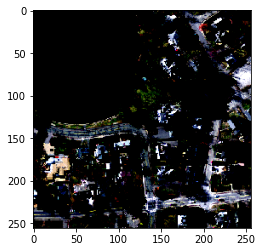

In [10]:
plt.imshow(img.permute(1, 2, 0))

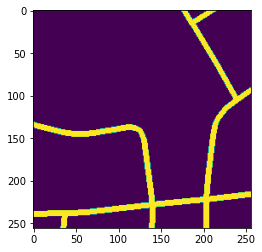

In [11]:
plt.imshow(mask)

In [12]:
print(np.unique(mask))

[0. 1.]


In [13]:
import torch 
import torch.nn as nn
from torch.nn.modules.conv import Conv2d

# Skip connection 
class Residual(nn.Module):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


# In this block we have n depth and in_dim and out_dim is equal. We will use it for the path aggregation.
def ConvMixer_Path(dim, depth, kernel_size=3, padding=1):
    return nn.Sequential(
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding=padding),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            
        ) for i in range(depth)]
    )

# In this block the depth is 1 and in_dim and out_dim is different. We will use this block in every stage of the U_Net
def ConvMixer_Block(in_dim, out_dim, kernel_size=3, padding=1):
    return nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(in_dim, in_dim, kernel_size=kernel_size, groups=in_dim, padding=padding),
                nn.BatchNorm2d(in_dim),
                nn.ReLU()
            )),
            nn.Conv2d(in_dim, out_dim, kernel_size=1),
        nn.BatchNorm2d(out_dim),    
        nn.ReLU()
    )


class DepthWiseInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1)
        self.conv3 = ConvMixer_Block(in_channels, int(out_channels/4))
        self.conv5 = nn.Sequential(ConvMixer_Block(in_channels, int(out_channels/4)),
                                    ConvMixer_Block(int(out_channels/4), int(out_channels/4)))
        self.conv7 = nn.Sequential(ConvMixer_Block(in_channels, int(out_channels/4)),
                                    ConvMixer_Block(int(out_channels/4), int(out_channels/4)),
                                    ConvMixer_Block(int(out_channels/4), int(out_channels/4)))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        a = self.conv1(x)
        b = self.conv3(x)
        c = self.conv5(x)
        d = self.conv7(x)

        cat = torch.cat([a, b, c, d], dim=1)
        x = self.batchnorm(cat)
        out = self.relu(cat)
       

        return out
#######################################



class ConvMixer_UNET_down(nn.Module):
    def __init__(self, num_classes):
        super(ConvMixer_UNET_down, self).__init__()
        self.num_classes = num_classes
        # Encoder Stage 1
        self.E_S1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  DepthWiseInceptionBlock(64, 64))
        # self.S1_path = ConvMixer_Path(64, 4)
        # self.S1_path_aggregate = Conv2d(64, 128, kernel_size=1) # The bottleneck layer that connects 1st stage path layer with second stage path

        self.E_S2 = nn.Sequential(DepthWiseInceptionBlock(64, 128),
                                  DepthWiseInceptionBlock(128, 128))

        # self.S2_path = ConvMixer_Path(128, 3)
        # self.S2_path_aggregate = Conv2d(128, 256, kernel_size=1)

        self.E_S3 = nn.Sequential(DepthWiseInceptionBlock(128, 256),
                                  DepthWiseInceptionBlock(256, 256))

        # self.S3_path = ConvMixer_Path(256, 2)
        # self.S3_path_aggregate = Conv2d(256, 512, kernel_size=1)

        self.E_S4 = nn.Sequential(DepthWiseInceptionBlock(256, 512),
                                  DepthWiseInceptionBlock(512, 512))

        # self.S4_path = ConvMixer_Path(512, 1)

        self.bridge = nn.Sequential(DepthWiseInceptionBlock(512, 1024),
                                    DepthWiseInceptionBlock(1024, 512))


        self.S4_up = nn.Sequential(#nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S3_up = nn.Sequential(#nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S2_up = nn.Sequential(#nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S1_up = nn.Sequential(#nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))



        self.D_S4 = nn.Sequential(DepthWiseInceptionBlock(1024, 512),
                                    DepthWiseInceptionBlock(512, 256))

        self.D_S3 = nn.Sequential(DepthWiseInceptionBlock(512,256),
                                    DepthWiseInceptionBlock(256, 128))

        self.D_S2 = nn.Sequential(DepthWiseInceptionBlock(256, 128),
                                    DepthWiseInceptionBlock(128, 64))

        self.D_S1 = nn.Sequential(DepthWiseInceptionBlock(128, 64),
                                    DepthWiseInceptionBlock(64, 64))


        self.max_pool = nn.MaxPool2d(2, 2)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e_s1_out = self.E_S1(x)
        # s1_path_out = self.S1_path(e_s1_out)
        # s1_path_aggregation = self.S1_path_aggregate(self.max_pool(s1_path_out)) # this is the block that accepts 1st layer path output and maxpools it and then increases the number of channels twice to concatenate with second layer
        x = self.max_pool(e_s1_out) 

        e_s2_out = self.E_S2(x)
        # s2_path_out = self.S2_path(e_s2_out)
        # s2_path_aggregation = self.S2_path_aggregate(self.max_pool(s2_path_out))
        x = self.max_pool(e_s2_out)

        e_s3_out = self.E_S3(x)
        # s3_path_out = self.S3_path(e_s3_out)
        # s3_path_aggregation = self.S3_path_aggregate(self.max_pool(s3_path_out))
        x = self.max_pool(e_s3_out)

        e_s4_out = self.E_S4(x)
        # s4_path_out =self.S4_path(e_s4_out)
        x = self.max_pool(e_s4_out)
        
        bridge = self.bridge(x)

        s4_up = self.S4_up(bridge)
        cat = torch.cat([s4_up, e_s4_out], dim=1)
        d4_out = self.D_S4(cat)

        s3_up = self.S3_up(d4_out)
        cat = torch.cat([s3_up, e_s3_out], dim=1)
        d3_out = self.D_S3(cat)

        s2_up = self.S2_up(d3_out)
        cat = torch.cat([s2_up, e_s2_out], dim=1)
        d2_out = self.D_S2(cat)

        s1_up = self.S1_up(d2_out)
        cat = torch.cat([s1_up, e_s1_out], dim=1)
        d1_out = self.D_S1(cat)

        out = self.final(d1_out)  

        return out

In [14]:
model = ConvMixer_UNET_down(CLASSES).to(DEVICE)

In [15]:
# Custom loss functions
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
#####################################################################################    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
#####################################################################################    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
#####################################################################################    
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss
    
    
#####################################################################################
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [16]:
# criterion = nn.BCEWithLogitsLoss().to(DEVICE)
# criterion = DiceLoss().to(DEVICE)
criterion = DiceBCELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=CLASSES):
    with torch.no_grad():
        pred_mask = nn.functional.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [18]:
def plot_images(img, mask, pred):
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[0].set_xlabel("Image")
    ax[1].imshow(mask)
    ax[1].set_xlabel("Ground Truth")
    ax[2].imshow(pred)
    ax[2].set_xlabel("Prediction")

In [ ]:
train_loss_values = []
valid_loss_values = []
train_iou_values = []
valid_iou_values = []

for epoch in range(200):
    loop = tqdm(train_loader)
    train_losses = []
    train_iou = []
    # training_loop
    model.train()
    for batch_id, (images, masks) in enumerate(loop):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.float().unsqueeze(1)
        
        outputs = model(images)
        

        loss = criterion(outputs, masks)
        train_losses.append(loss.item())
        
        iou = mIoU(outputs, masks)
        train_iou.append(iou)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss=loss.item(), train_miou=iou)
        
    # Validation loop    
    model.eval()
    valid_losses = []
    valid_iou = []

    with torch.no_grad():
        loop = tqdm(valid_loader)
        for i, (images, masks) in enumerate(loop):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.float().unsqueeze(1)

            outputs = model(images)
            
            if (epoch+1) % 10 == 0:
                img = images[0].permute(1, 2, 0).cpu()
                mask = masks[0].squeeze(0).cpu()
                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                pred = preds[0].cpu().squeeze(0)

                plot_images(img, mask, pred)
            
            val_loss = criterion(outputs, masks)
            valid_losses.append(val_loss.item())

            val_iou = mIoU(outputs, masks)
            valid_iou.append(val_iou)
            
            loop.set_postfix(valid_loss=val_loss.item(), valid_miou=val_iou)
                
        
        
    scheduler.step()
        
    train_loss_values.append(np.mean(train_losses))
    valid_loss_values.append(np.mean(valid_losses))
    train_iou_values.append(np.mean(train_iou))
    valid_iou_values.append(np.mean(valid_iou))
    
    
    if (epoch+1) % 10 == 0:
        torch.save(model.state_dict(), "A_Small.pt")
        
        
        
        
    print(f"Epoch-{epoch+1} Train mean loss: {np.mean(train_losses):.4f} Train MIOU: {np.mean(train_iou):.4f}")
    print(f"Epoch-{epoch+1} Valid mean loss: {np.mean(valid_losses):.4f} Valid MIOU: {np.mean(valid_iou):.4f}")

  0%|          | 0/139 [00:00<?, ?it/s]/data1/hom1/ict11/.conda/envs/ict11-smp/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 91%|█████████▏| 127/139 [01:00<00:05,  2.33it/s, train_loss=0.818, train_miou=0.609]

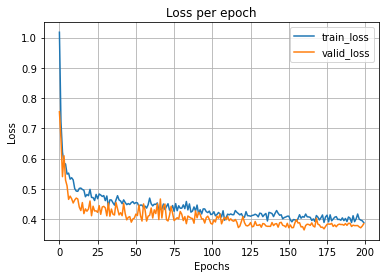

In [20]:
#Plotting Loss
plt.plot(train_loss_values, label='train_loss')
plt.plot(valid_loss_values, label='valid_loss')
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

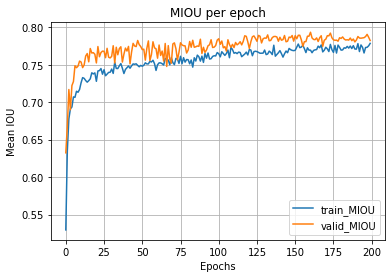

In [21]:
# Plotting Mean IOU
plt.plot(train_iou_values, label='train_MIOU')
plt.plot(valid_iou_values, label='valid_MIOU')
plt.title('MIOU per epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.legend()
plt.grid()
plt.show()

In [19]:
# inference_model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
weights = torch.load("A_Small.pt")
model.load_state_dict(weights)



def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


model.eval()
with torch.no_grad():
    total_list = []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).squeeze(1).long()
        
        outputs = model(images)
        miou_list = mIoU(pred_mask = outputs, mask=masks, n_classes=2) 
        total_list.append(miou_list)
print(np.mean(total_list))

  0%|          | 0/25 [00:00<?, ?it/s]/data1/hom1/ict11/.conda/envs/ict11-smp/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 25/25 [00:26<00:00,  1.04s/it]

0.8108825906699764


In [21]:
# inference_model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
weights = torch.load("A_Small.pt")
model.load_state_dict(weights)



def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


model.eval()
with torch.no_grad():
    total_list = []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).squeeze(1).long()
        
        outputs = model(images)
        miou_list = mIoU(pred_mask = outputs, mask=masks, n_classes=2) 
        total_list.append(miou_list)
print(np.mean(total_list))

  0%|          | 0/25 [00:00<?, ?it/s]/data1/hom1/ict11/.conda/envs/ict11-smp/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 25/25 [00:24<00:00,  1.01it/s]

0.7941163291737692


In [20]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unnorm = UnNormalize(mean=[0.4299, 0.4328, 0.3964], std=[0.2711, 0.2666, 0.2816])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

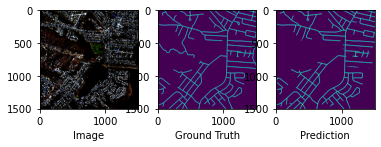

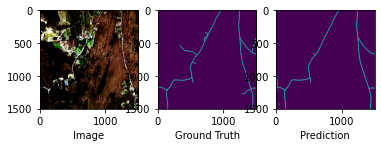

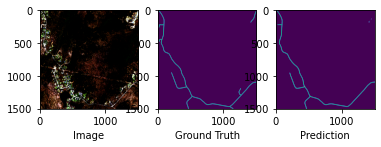

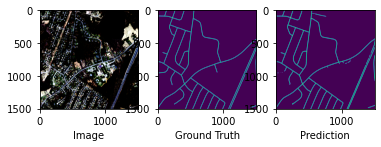

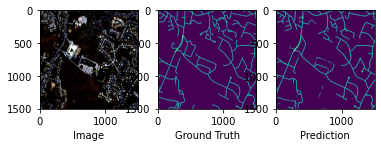

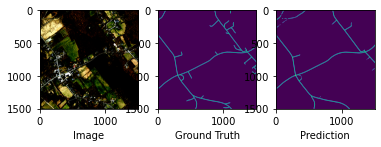

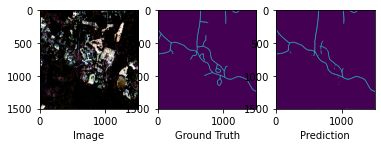

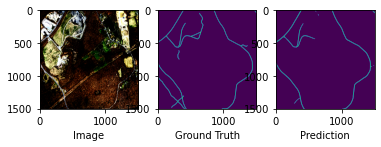

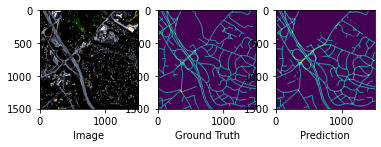

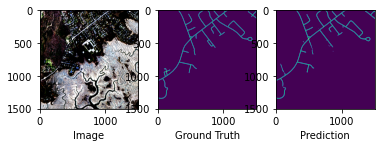

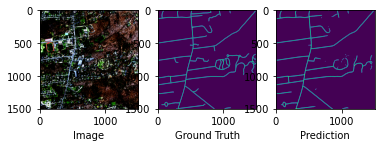

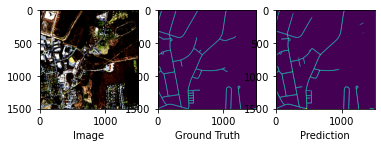

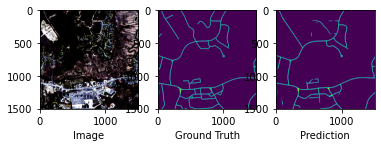

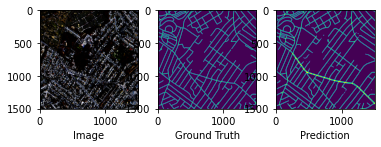

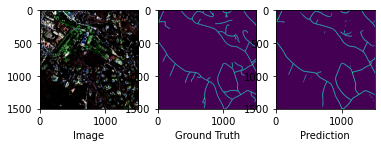

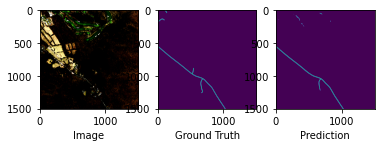

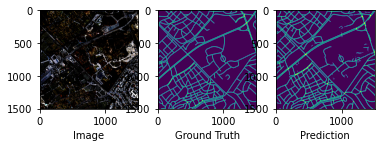

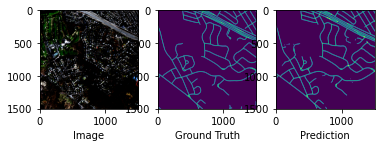

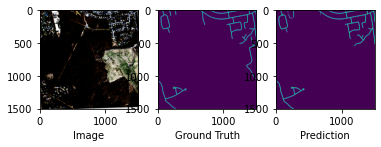

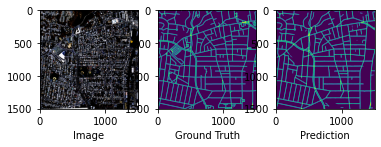

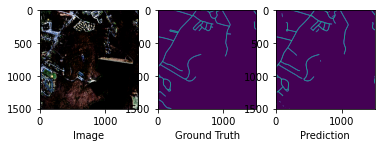

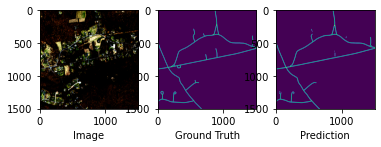

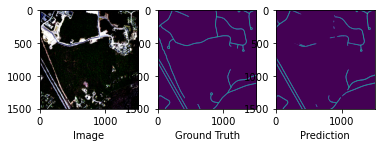

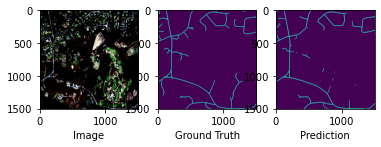

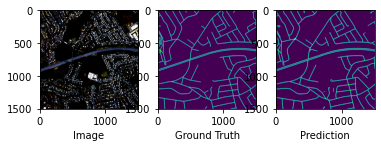

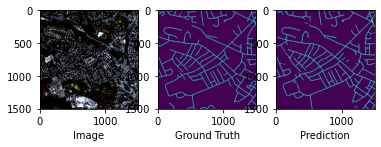

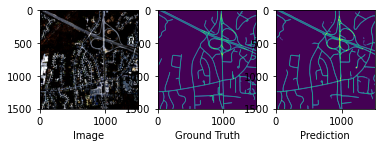

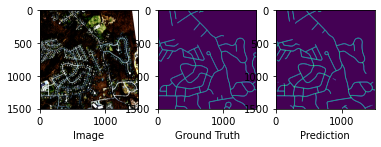

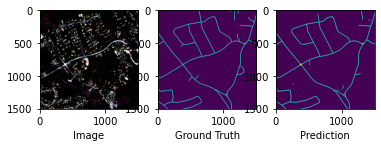

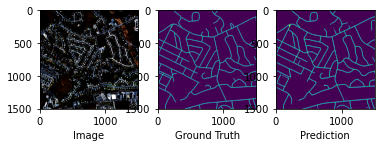

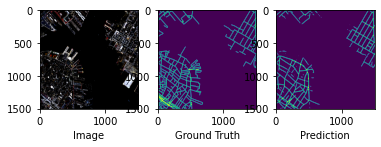

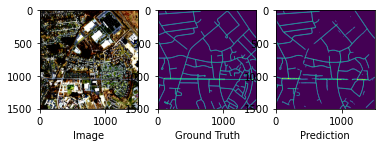

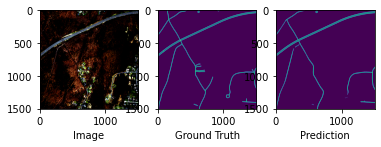

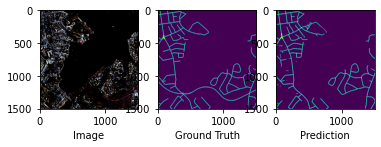

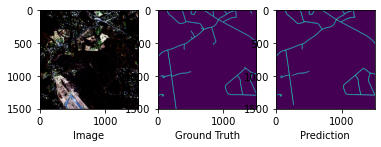

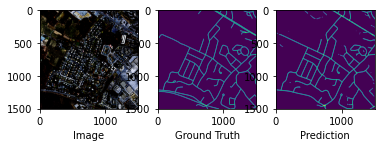

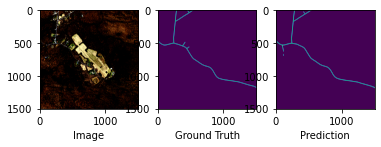

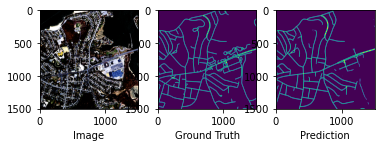

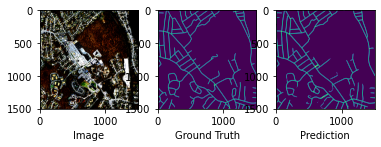

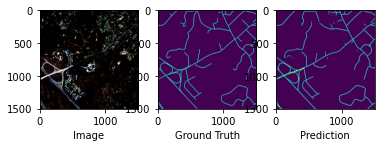

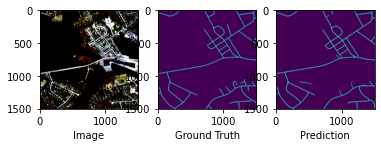

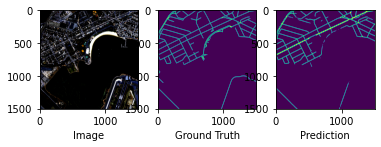

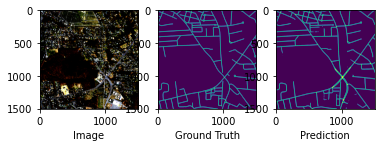

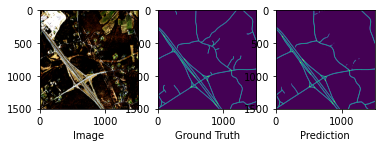

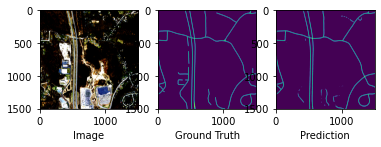

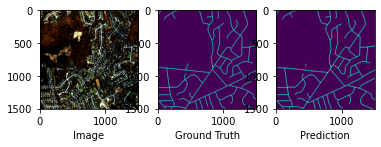

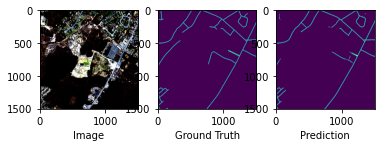

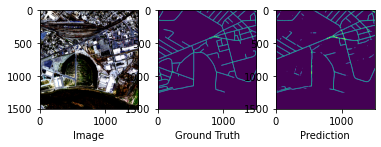

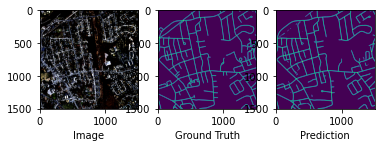

In [21]:
with torch.no_grad():
    model.eval()
    folder = 'Image_results/Model_A'
    for i, data in enumerate(test_set):
        images, masks = data
        images = images.unsqueeze(0).to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.float()

        outputs = model(images)

        img = images.squeeze(0).permute(1, 2, 0).cpu()
        mask = masks.squeeze(0).cpu()
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        pred = preds[0].cpu().squeeze(0)
        pred[pred == 1] = 255
        
        image = unnorm(images)
        torchvision.utils.save_image(image, f"{folder}/image_{i}.png")
        torchvision.utils.save_image(masks, f"{folder}/mask_{i}.png")
        torchvision.utils.save_image(pred, f"{folder}/pred_{i}.png")

        plot_images(img, mask, pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


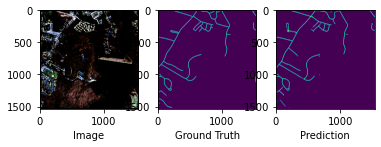

In [24]:
with torch.no_grad():
    model.eval()
    images, masks = test_set[20]
    images = images.unsqueeze(0).to(DEVICE)
    masks = masks.to(DEVICE)
    masks = masks.float()

    outputs = model(images)

    img = images.squeeze(0).permute(1, 2, 0).cpu()
    mask = masks.squeeze(0).cpu()
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()
    pred = preds[0].cpu().squeeze(0)

    plot_images(img, mask, pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


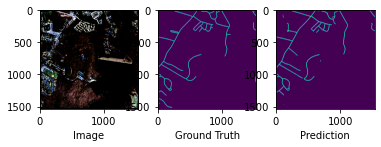

In [23]:
with torch.no_grad():
    model.eval()
    images, masks = test_set[20]
    images = images.unsqueeze(0).to(DEVICE)
    masks = masks.to(DEVICE)
    masks = masks.float()

    outputs = model(images)

    img = images.squeeze(0).permute(1, 2, 0).cpu()
    mask = masks.squeeze(0).cpu()
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()
    pred = preds[0].cpu().squeeze(0)

    plot_images(img, mask, pred)
   

In [22]:
# Image size = 1536
import torchmetrics as tm
f1 = tm.F1(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
p = tm.Precision(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
r = tm.Recall(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')

model.eval()
with torch.no_grad():
    iou_list, f1_list, p_list, r_list = [], [], [], []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).long()
        
        
        outputs = model(images).squeeze(1)
#         pred_mask = nn.functional.sigmoid(outputs)
#         pred_mask = (pred_mask > 0.5).long()
#         print(masks.shape, outputs.shape)
        
        iou = mIoU(outputs.cpu(), masks.cpu())
        fone = f1(outputs.cpu(), masks.cpu())
        pi = p(outputs.cpu(), masks.cpu())
        ar = r(outputs.cpu(), masks.cpu())
        
        iou_list.append(iou)
        f1_list.append(fone)
        p_list.append(pi)
        r_list.append(ar)
        
print(np.mean(iou_list), np.mean(f1_list), np.mean(p_list), np.mean(r_list))


100%|██████████| 25/25 [01:24<00:00,  3.38s/it]

0.8031205875453648 0.8786728 0.88725364 0.8730728


In [20]:
# Image size = 1504
import torchmetrics as tm
f1 = tm.F1(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
p = tm.Precision(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
r = tm.Recall(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')

model.eval()
with torch.no_grad():
    iou_list, f1_list, p_list, r_list = [], [], [], []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).long()
        
        
        outputs = model(images).squeeze(1)
#         pred_mask = nn.functional.sigmoid(outputs)
#         pred_mask = (pred_mask > 0.5).long()
#         print(masks.shape, outputs.shape)
        
        iou = mIoU(outputs.cpu(), masks.cpu())
        fone = f1(outputs.cpu(), masks.cpu())
        pi = p(outputs.cpu(), masks.cpu())
        ar = r(outputs.cpu(), masks.cpu())
        
        iou_list.append(iou)
        f1_list.append(fone)
        p_list.append(pi)
        r_list.append(ar)
        
print(np.mean(iou_list), np.mean(f1_list), np.mean(p_list), np.mean(r_list))

100%|██████████| 25/25 [01:26<00:00,  3.46s/it]

0.8111317314535563 0.8864458 0.900602 0.87550527


In [22]:
# Image size = 1504 not padifneeded
import torchmetrics as tm
f1 = tm.F1(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
p = tm.Precision(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
r = tm.Recall(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')

model.eval()
with torch.no_grad():
    iou_list, f1_list, p_list, r_list = [], [], [], []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).long()
        
        
        outputs = model(images).squeeze(1)
#         pred_mask = nn.functional.sigmoid(outputs)
#         pred_mask = (pred_mask > 0.5).long()
#         print(masks.shape, outputs.shape)
        
        iou = mIoU(outputs.cpu(), masks.cpu())
        fone = f1(outputs.cpu(), masks.cpu())
        pi = p(outputs.cpu(), masks.cpu())
        ar = r(outputs.cpu(), masks.cpu())
        
        iou_list.append(iou)
        f1_list.append(fone)
        p_list.append(pi)
        r_list.append(ar)
        
print(np.mean(iou_list), np.mean(f1_list), np.mean(p_list), np.mean(r_list))

100%|██████████| 25/25 [01:25<00:00,  3.42s/it]


0.7934775771108535 0.87249434 0.8900386 0.85893065


In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=CLASSES):
    with torch.no_grad():
        pred_mask = nn.functional.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [21]:
# inference_model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
weights = torch.load("A_Small.pt")
model.load_state_dict(weights)


# Image size = 1504 not padifneeded
import torchmetrics as tm
f1 = tm.F1(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
p = tm.Precision(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')
r = tm.Recall(num_classes=2, average='macro', multiclass=True, mdmc_average='samplewise')

model.eval()
with torch.no_grad():
    iou_list, f1_list, p_list, r_list = [], [], [], []
    for batch_id, (images, masks) in enumerate (tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).long()
        
        
        outputs = model(images).squeeze(1)
        outputs = outputs[:, 18 :1518, 18:1518]
        masks = masks[:, 18:1518, 18:1518]
#         pred_mask = nn.functional.sigmoid(outputs)
#         pred_mask = (pred_mask > 0.5).long()
#         print(masks.shape, outputs.shape)
        
        iou = mIoU(outputs.cpu(), masks.cpu())
        fone = f1(outputs.cpu(), masks.cpu())
        pi = p(outputs.cpu(), masks.cpu())
        ar = r(outputs.cpu(), masks.cpu())
        
        iou_list.append(iou)
        f1_list.append(fone)
        p_list.append(pi)
        r_list.append(ar)
        
print(np.mean(iou_list), np.mean(f1_list), np.mean(p_list), np.mean(r_list))

  0%|          | 0/25 [00:00<?, ?it/s]/data1/hom1/ict11/.conda/envs/ict11-smp/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 25/25 [01:26<00:00,  3.47s/it]

0.813570273114916 0.8856912 0.90325224 0.87211174
